In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from sklearn import linear_model

from umap_lime import *

In [2]:
# import importlib 
# importlib.reload(umap_lime)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [4]:
from fashion_model import FashionCNN 

checkpt_file = 'pretrained/fashionCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))

pretrained/fashionCNN.pt


<All keys matched successfully>

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

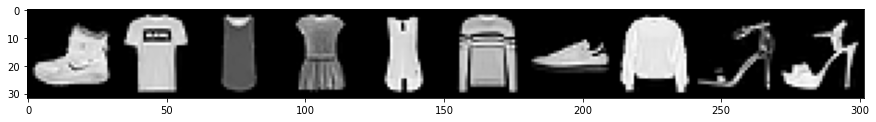

In [5]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


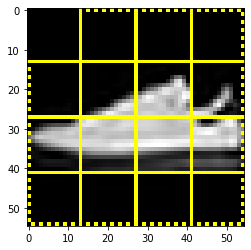

In [44]:
sample_idx = 6
ex_img = images[sample_idx]
np_img, np_3D_img, segments_slic = segment_img(ex_img, n_segments=16, compactness=100, sigma=1, start_label=0)
plt.imshow(mark_boundaries(np_3D_img, segments_slic, mode = 'subpixel'))

In [45]:
n_samples = 100

In [46]:
lime_seeds, lime_perturbations, lime_similarities, segments_slic = lime_perturb_gen(ex_img, 
                                                                             no_samples = n_samples,
                                                                             n_segments = 16, slic_compactness = 100, 
                                                                             slic_sigma = 1, start_label = 0,
                                                                             perturb_prob = 0.1, perturb_sigma = 1,
                                                                             kernel_width = 4)

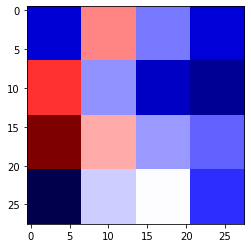

In [47]:
lime_perturb_targets = get_preds(model, ex_img, lime_perturbations, device, kernel_width = 4)

lime_explanation = fit_interpretable_model(lime_seeds, lime_perturb_targets, lime_similarities)
lime_explanation_mask = np.zeros_like(segments_slic).astype('float64')
for k, v in zip(np.unique(segments_slic).tolist(), lime_explanation):
    lime_explanation_mask[segments_slic == k] = v

plt.imshow(lime_explanation_mask, cmap=plt.get_cmap('seismic'))

In [10]:
all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))
umap_sampling = UMAP_sampling(all_images)

In [29]:
ulime_seeds, ulime_perturbations, ulime_similarities, ulime_diff = umap_sampling.perturbations_generator(ex_img, no_samples = n_samples, 
                                                                                                           perturb_sigma = 10,
                                                                                                           perturb_prob = 0.5,
                                                                                                           constant_noise_mag = False,
                                                                                                           mode = 'discrete',
                                                                                                           kernel_width = 4,
                                                                                                        low_manifold= True)

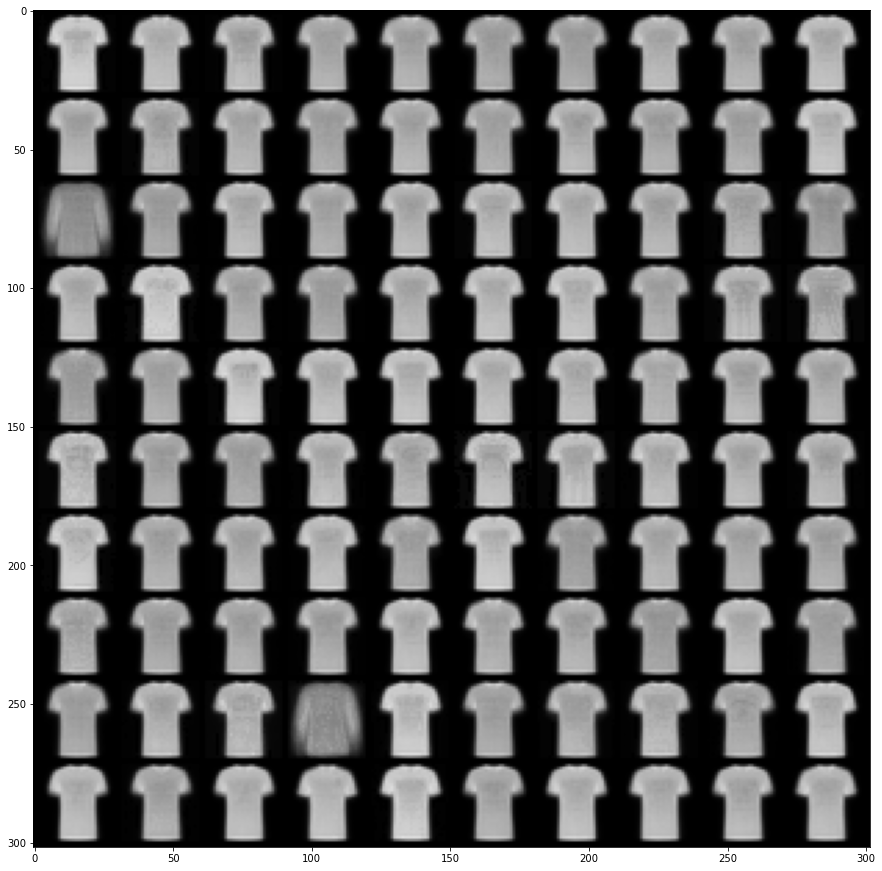

In [30]:
grid = torchvision.utils.make_grid(ulime_perturbations, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [31]:
ulime_perturb_targets = get_preds(model, ex_img, ulime_perturbations.float(), device, kernel_width = 4)

In [32]:
# clf_seed = np.abs(ulime_diff)*(1-ulime_seeds)
clf_seed = np.abs(ulime_diff)
ulime_explanation = fit_interpretable_model(clf_seed.reshape(n_samples, -1), ulime_perturb_targets, ulime_similarities)
ulime_explanation = ulime_explanation.reshape(28, 28)

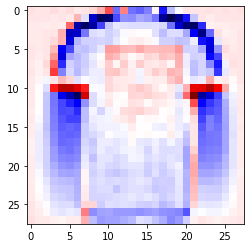

In [33]:
plt.imshow(ulime_explanation, cmap=plt.get_cmap('seismic'))

In [16]:
ulime_explanation.shape

(28, 28)

In [17]:
lime_explanation_mask.shape

(28, 28)

In [18]:
ex_img[0].cpu().detach().numpy().shape

(28, 28)

In [19]:
import pickle



result = [ex_img[0].cpu().detach().numpy(), ulime_explanation, lime_explanation_mask]

with open('Explanation.pickle', 'wb') as output:
    pickle.dump(result, output)

In [71]:
explain_file = 'results/time/ulime_time_' + str(0) + '_.pickle'
with open(explain_file, 'rb') as file:
    load_result = pickle.load(file)

In [72]:
load_result

[0, 133.7095193862915, 10.233295679092407, 130.99786710739136]

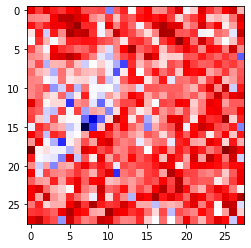

In [67]:
plt.imshow(load_result[4], cmap=plt.get_cmap('seismic'))

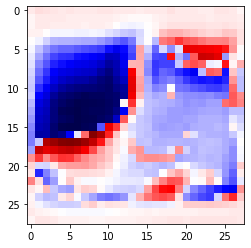

In [68]:
plt.imshow(load_result[3], cmap=plt.get_cmap('seismic'))

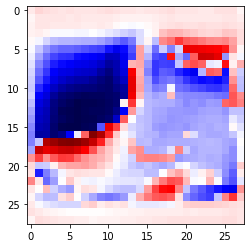

In [69]:
plt.imshow(load_result[2], cmap=plt.get_cmap('seismic'))